# COMP3800 Final Project: PetFinder
From kaggle.com, the main concern of this project is to predict the adoption speed of sheltered animals using the given datasets for a Malaysian website petfinder.my.

## Datasets

#### Labels
* Breeds
* Colors
* States

#### Data
* train
* test

#### Images

In [154]:
import pandas as pd

In [155]:
# load breed labels
breeds = pd.read_csv('~/Files/petfinder-adoption-prediction/breed_labels.csv')
# breeds.head()

In [156]:
# load color labels
colors = pd.read_csv('~/Files/petfinder-adoption-prediction/color_labels.csv')
# colors

In [157]:
# load states labels
states = pd.read_csv('~/Files/petfinder-adoption-prediction/state_labels.csv')
# states.head()

In [199]:
# load datasets
train = pd.read_csv('~/Files/petfinder-adoption-prediction/train.csv')
test = pd.read_csv('~/Files/petfinder-adoption-prediction/test/test.csv')

# create a combination of two datasets
train['Dataset'] = 'train'
test['Dataset'] = 'test'
data = pd.concat([train, test], sort=False)

# data.info()


## Adoption Speed

* 0: Adopted __on the day__ it was listed
* 1: Adopted __within a week__ after being listed
* 2: Adopted __within a month__ after being listed
* 3: Adopted __within 3 months__ after being listed
* 4: Adopted __after 100 days__ or __not adopted__ after being listed

### Overall

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()
plt.style.use('seaborn-pastel')


def show_percentage(axes, bars, total, place='center', fontsize=12, 
                    color='black', textcoords='offset points'):
    for bar in bars:
        percent = bar.get_height()*100/total
        x = bar.get_x()+bar.get_width()/2.
        y = bar.get_height()/2
        if (place == 'top'):
            y = bar.get_height()
        
        axes.annotate(
            "%.2f%%" % percent, (x, y), ha='center', va='center',
            fontsize=fontsize, color=color, xytext=(0,0), 
            rotation=0, textcoords=textcoords
        )
        
        
def show_values(axes, bars):
    for bar in bars:
        height = bar.get_height()
        axes.text(bar.get_x()+bar.get_width()/2., height+5, 
                  '%d' % int(height), ha='center', va='bottom')

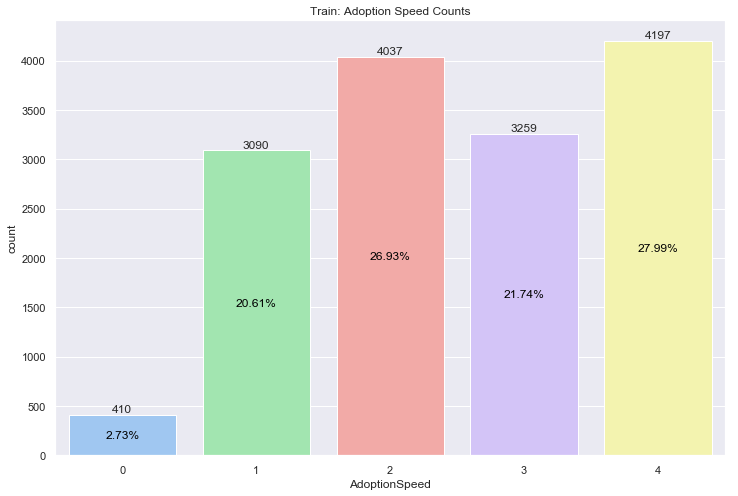

In [160]:
# plot adoption speed for train set

# speed_counts = data['AdoptionSpeed'].value_counts()
# speed_counts.index = speed_counts.index.astype(dtype=int)
# plt.bar(speed_counts.index, height=speed_counts, width=0.5, color='teal')

speed_counts = train[['AdoptionSpeed']][train['AdoptionSpeed'] < 5.0].astype(int)

plt.figure(figsize=(12, 8))
speed_plot = sns.countplot(x='AdoptionSpeed', data=speed_counts)
ax = speed_plot.axes
plt.title("Train: Adoption Speed Counts")
show_percentage(ax, ax.patches, train.shape[0])
show_values(ax, ax.patches)

# plt.savefig('speed_counts.jpg', dpi=300)
# speed_counts.value_counts()

Note that only 79.15% of the animal in our datasets has their adoption speed recorded.

We can see that most of the animals in this adoption website won't get adopted after a week. More than 20% won't get adopted until after 3 months or even not at all.

### Adoption Speed by Type
#### Types
* 1 - Dog
* 2 - Cat

All animals in our dataset are either a dog or a cat.

In [206]:
# Convert types to their respective names for the ease of visualization
train['TypeName'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
test['TypeName'] = test['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
data['TypeName'] = data['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

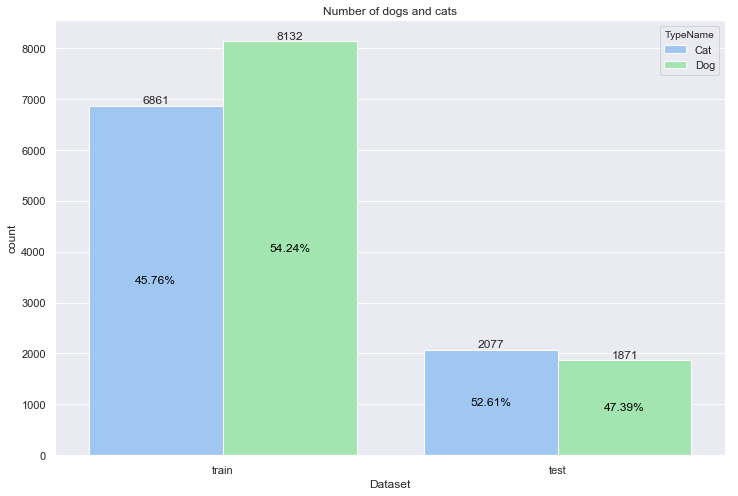

In [101]:
plt.figure(figsize=(12, 8))
type_plot = sns.countplot(x='Dataset', data=data, hue='TypeName')
plt.title('Number of dogs and cats')

ax = type_plot.axes
show_percentage(ax, ax.patches[0::2], train.shape[0])
show_percentage(ax, ax.patches[1::2], test.shape[0])
show_values(ax, ax.patches)

# plt.savefig('type_counts.jpg', dpi=300)
# data[data['Dataset'] == 'train'].shape[0], data[data['Dataset'] == 'test'].shape[0]

We can see that there are more dogs in the training set than the testing set, but it should not have a huge influence on the result.

### Adoption Speed Rate Comparison

Let's use the rate of each adoption speed in _train_ as base rates. For example:

There are 410 animals with speed 0, so 410 / 14993 = 0.0273

In [162]:
train[train['AdoptionSpeed'] == 0].shape[0] / train.shape[0]

0.027346094844260656

In [103]:
main_count = train['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h), ha='center', va='center', 
                    fontsize=11, color='green' if plot_dict[h] > 0 else 'red', 
                    rotation=0, xytext=(0, 10), textcoords='offset points')  

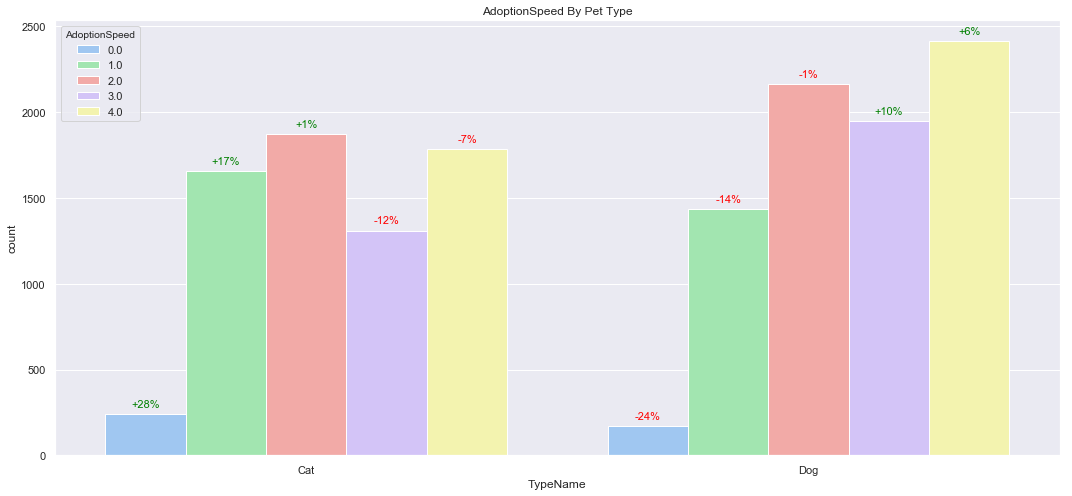

In [104]:
plt.figure(figsize=(18, 8))
count_plot(data.loc[data['Dataset'] == 'train'], x='TypeName', title='By Pet Type')

# plt.savefig('adoption_speed_by_type.jpg', dpi=300)

The percentage above each bar represents the comparison of that category relative to its corresponding base rate, which in this case is about 0.27. 

For example, the first bar tells us that if the animal is a cat, the chance of it being adopted on the day it is listed is 28% higher, whereas it's 24% lower if it was a dog.

### Name
One type of information given to us in the datasets is the animal's names. I think the effect on adoption speed caused by name is trivial, but let's check it out.

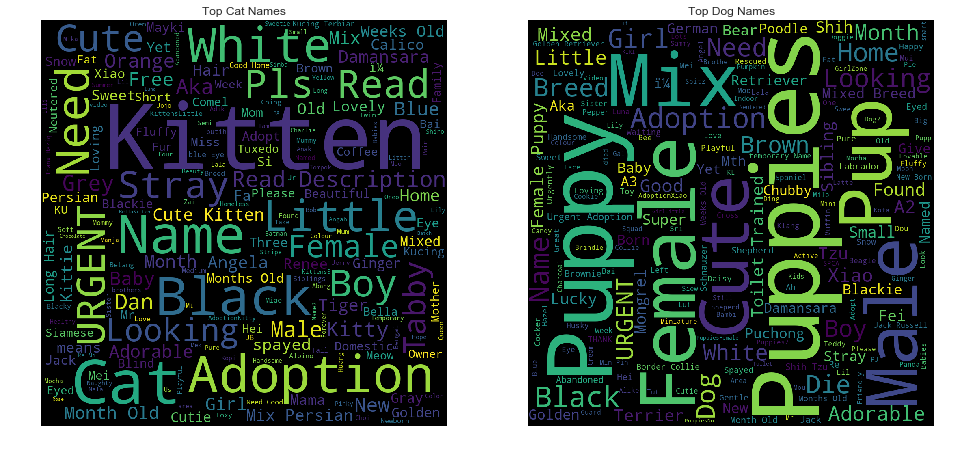

In [105]:
from wordcloud import WordCloud

_, _ = plt.subplots(figsize=(16, 16))

plt.subplot(1, 2, 1)
cat_names = ''.join(data.loc[data['TypeName'] == 'Cat', 'Name'].fillna('').values)
wordcloud = WordCloud(width=1000, height=1000).generate(cat_names)
# wordcloud.to_file('top_cat_names.jpg')

plt.imshow(wordcloud)
plt.title('Top Cat Names')
plt.axis('off')

plt.subplot(1, 2, 2)
dog_names = ''.join(data.loc[data['TypeName'] == 'Dog', 'Name'].fillna('').values)
wordcloud = WordCloud(width=1000, height=1000).generate(dog_names)
# wordcloud.to_file('top_dog_names.jpg')

plt.imshow(wordcloud)
plt.title('Top Dog Names')
plt.axis('off')

plt.show()
# plt.savefig('top_names.jpg', dpi=300)

It's worth noticing that some names are very general while others are more normal.

Some names we can see:
* Information of the animal: "Puppies", "Black", "Mix", "Female"
* Adoption-related messages: "Looking", "Urgent", "Adoption"
* Descriptive: "Adorable", "Cutie", "Trained"
* Normal names: "Bella", "Coffee", "Daisy"

Let's check out some of the most popular names.

In [106]:
df_names_count = pd.DataFrame()
for name in train['Name'].value_counts()[:5].index:
    df_names_count[name] = train[train['Name'] == name]['AdoptionSpeed'].value_counts()

df_names_count

,Baby,Lucky,Brownie,No Name,Mimi
4,27,17,16,20,17
2,15,16,14,11,13
3,11,12,12,6,7
1,11,14,11,14,12
0,2,5,1,3,3


Some animals have no names. Generalizing them into a common name would be helpful.

In [207]:
train.loc[train['Name'] == 'No Name', 'Name'] = 'Unnamed'
train['Name'].fillna('Unnamed', inplace=True)

test.loc[test['Name'] == 'No Name', 'Name'] = 'Unnamed'
test['Name'].fillna('Unnamed', inplace=True)

data.loc[data['Name'] == 'No Name', 'Name'] = 'Unnamed'
data['Name'].fillna('Unnamed', inplace=True)

print('Unnamed in train: %.3f%%' % ((train[train['Name'] == 'Unnamed'].shape[0] / train.shape[0])*100))
print("Unnamed in test: %.3f%%" % ((test[test['Name'] == 'Unnamed'].shape[0] / test.shape[0])*100))
print("Unnamed in all data: %.3f%%" % ((data[data['Name'] == 'Unnamed'].shape[0] / data.shape[0])*100))

Unnamed in train: 8.777%
Unnamed in test: 7.979%
Unnamed in all data: 8.611%


Let's see the adoption speed for the unnamed animals.

In [164]:
train[train['Name'] == 'Unnamed']['AdoptionSpeed'].value_counts()

4    454
2    324
1    285
3    224
0     29
Name: AdoptionSpeed, dtype: int64

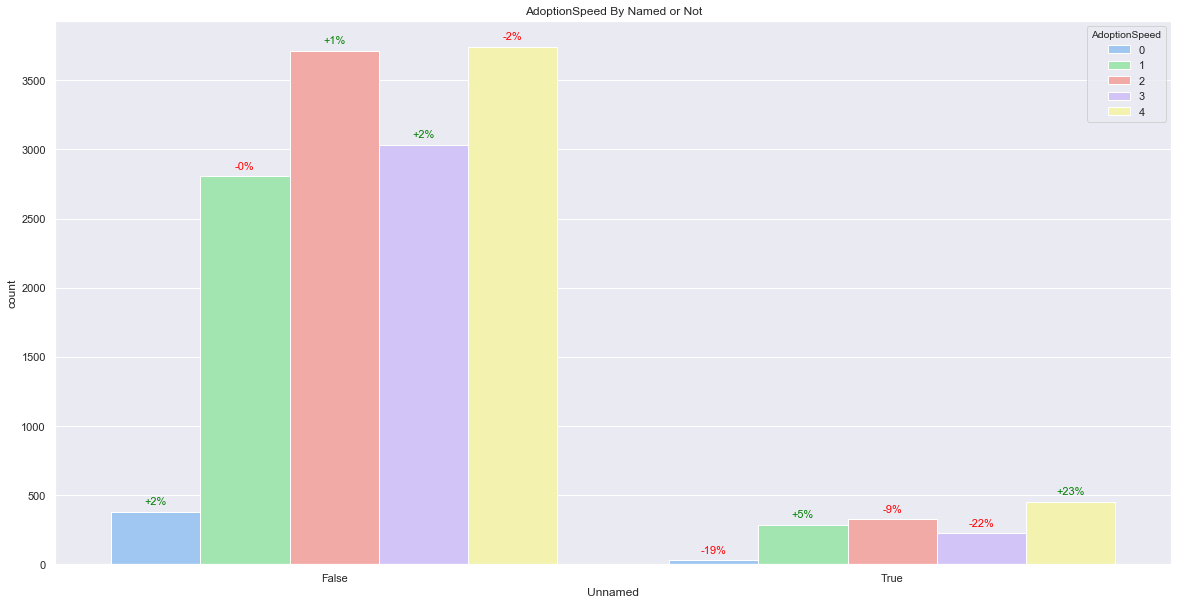

In [208]:
train['Unnamed'] = (train['Name'] == 'Unnamed')
test['Unnamed'] = (test['Name'] == 'Unnamed')
data['Unnamed'] = (data['Name'] == 'Unnamed')

plt.figure(figsize=(20, 10))
count_plot(train, x='Unnamed', title='By Named or Not')

# plt.savefig('nameliness.jpg', dpi=300)

We also saw some "bad" names in our dataset. We should look deeper into them.

In [209]:
is_short = lambda x: len(x) < 3
short_names = train[train['Name'].apply(is_short)]['Name']

train['ShortName'] = train['Name'].map(is_short)
test['ShortName'] = test['Name'].map(is_short)
data['ShortName'] = data['Name'].map(is_short)

train[train['ShortName']]['AdoptionSpeed'].value_counts()

3    71
2    61
1    48
4    32
0     4
Name: AdoptionSpeed, dtype: int64

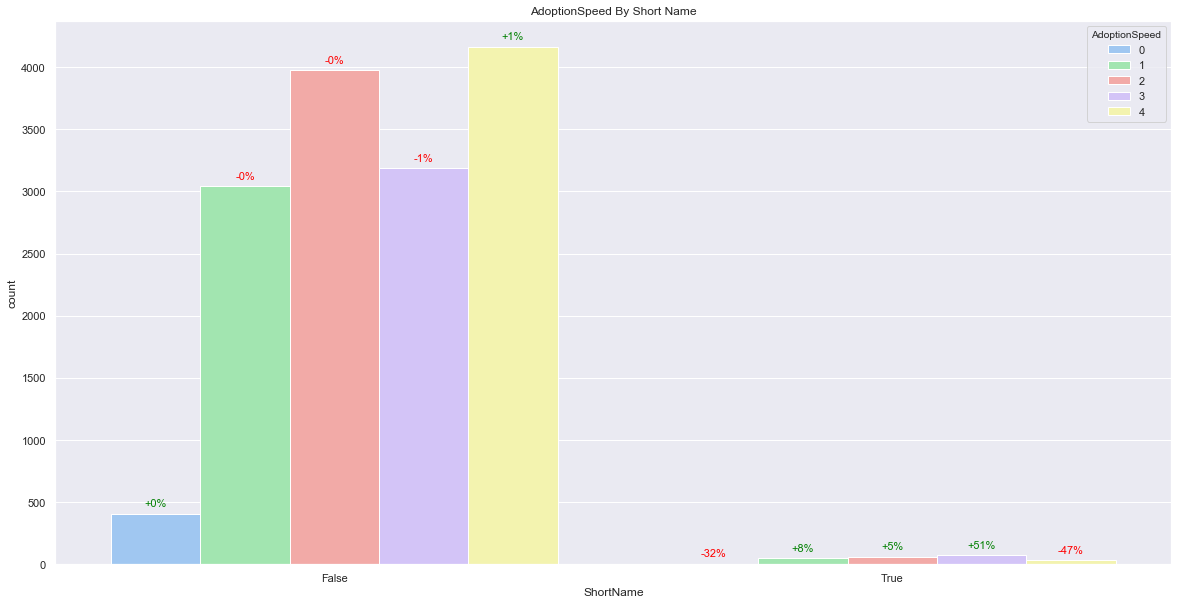

In [111]:
plt.figure(figsize=(20, 10))
count_plot(train, x='ShortName', title='By Short Name')
# plt.savefig('short_names.jpg', dpi=300)

### Age

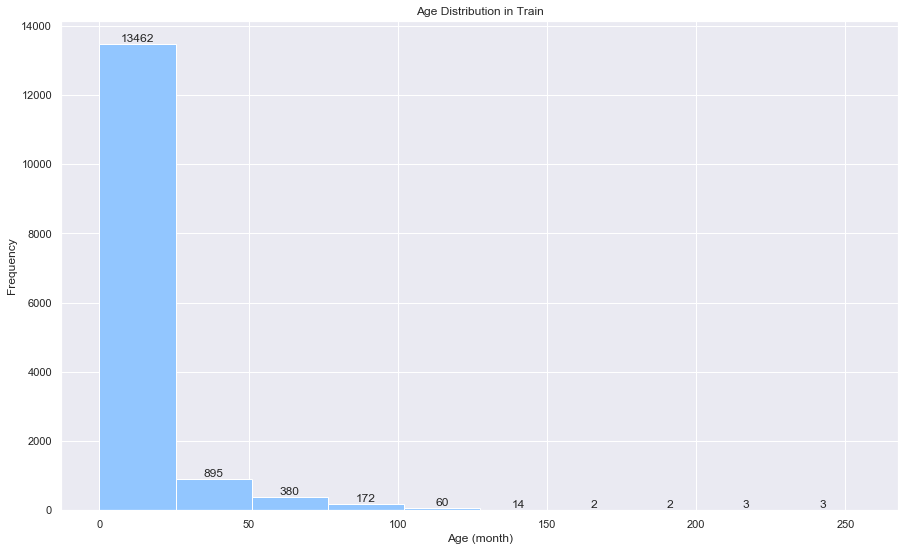

In [112]:
plt.figure(figsize=(15, 9))
ax = train['Age'].plot('hist', label='train')

plt.title('Age Distribution in Train')
plt.xlabel('Age (month)')
show_values(ax, ax.patches)

# plt.savefig('age_distribution.jpg', dpi=300)

In [210]:
train['TypeName'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')
train['TypeName'] = train['Type'].apply(lambda x: 'Cat' if x == 2 else x)

Text(0.5, 1.0, 'Age vs. AdoptionSpeed by Type')

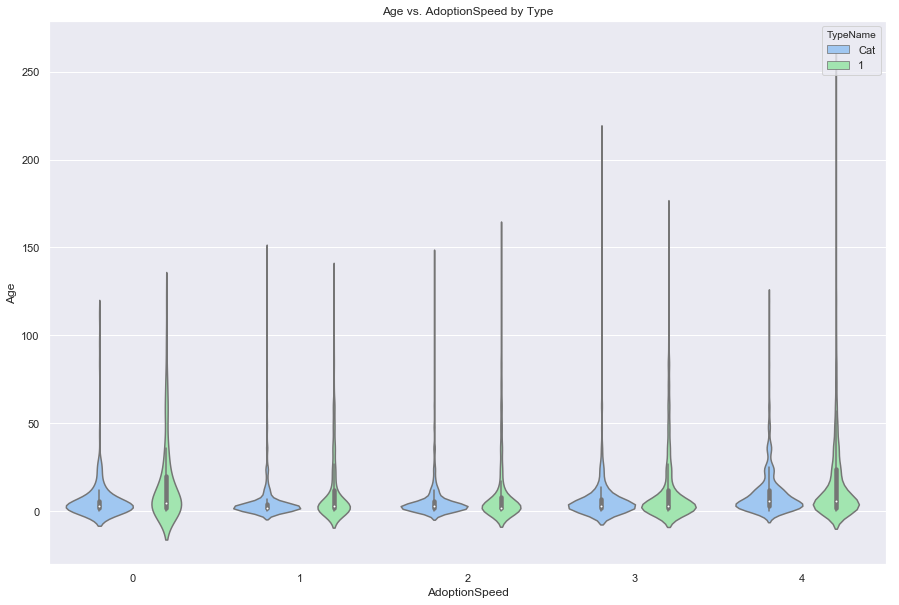

In [114]:
plt.figure(figsize=(15,10))
sns.violinplot(x='AdoptionSpeed', y='Age', hue='TypeName', data=train)
plt.title('Age vs. AdoptionSpeed by Type')
# plt.savefig('age_speed.jpg', dpi=300)

It's obvious that the fastest-adopted animals are generally younger than those who waited longer. We can see that especially on dogs.

### Breeds

In [211]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Dataset', 'TypeName', 'Unnamed', 'ShortName'],
      dtype='object')

In [170]:
print('%d animals in train have no breed information' % (train['Breed1'] == 0).sum())
print('%d animals in test have no breed information' % (test['Breed1'] == 0).sum())
print('%.2f%% of train are pure breeds' % (((train['Breed2'] == 0).sum() / train.shape[0])*100))
print('%.2f%% of test are pure breeds' % (((test['Breed2'] == 0).sum() / test.shape[0])*100))

5 animals in train have no breed information
0 animals in test have no breed information
71.78% of train are pure breeds
77.96% of test are pure breeds


We can see that there are columns "Breed1" and "Breed2", indicating that an animal may be mixed.

Only 5 animals in about 15000 have no breed information in our train set, so it's negligible.

Train and test have around the same portion of pure breeds.

We should generalize them into one category, similarly.

In [212]:
train['PureBreed'] = True
train.loc[train['Breed2'] != 0, 'PureBreed'] = False

test['PureBreed'] = True
test.loc[test['Breed2'] != 0, 'PureBreed'] = False

data['PureBreed'] = True
data.loc[data['Breed2'] != 0, 'PureBreed'] = False

Let's also look into the detailed breeds.

In [172]:
breeds_dict = {k: v for k, v in zip(breeds['BreedID'], breeds['BreedName'])}

In [213]:
train['Breed1_Name'] = train['Breed1'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else 'Unknown')
train['Breed2_Name'] = train['Breed2'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else '-')

test['Breed1_Name'] = test['Breed1'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else 'Unknown')
test['Breed2_Name'] = test['Breed2'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else '-')

data['Breed1_Name'] = data['Breed1'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else 'Unknown')
data['Breed2_Name'] = data['Breed2'].apply(lambda breed: breeds_dict[breed] if breed in breeds_dict else '-')

In [174]:
print(train['Breed1_Name'].value_counts().head())
print()
print(train['Breed2_Name'].value_counts().head())

Mixed Breed             5927
Domestic Short Hair     3634
Domestic Medium Hair    1258
Tabby                    342
Domestic Long Hair       296
Name: Breed1_Name, dtype: int64

-                       10762
Mixed Breed              1727
Domestic Short Hair       599
Domestic Medium Hair      321
Tabby                     138
Name: Breed2_Name, dtype: int64


Surprisingly, a lot of what we thought are pure breeds are actually mixed, but people didn't bother to input the second breed and simply put "Mixed_Breed" as the first breed.

This should affect our result significantly.

In [214]:
train.loc[train['Breed1_Name'] == 'Mixed_Breed', 'PureBreed'] = False
test.loc[test['Breed1_Name'] == 'Mixed_Breed', 'PureBreed'] = False
data.loc[data['Breed1_Name'] == 'Mixed_Breed', 'PureBreed'] = False

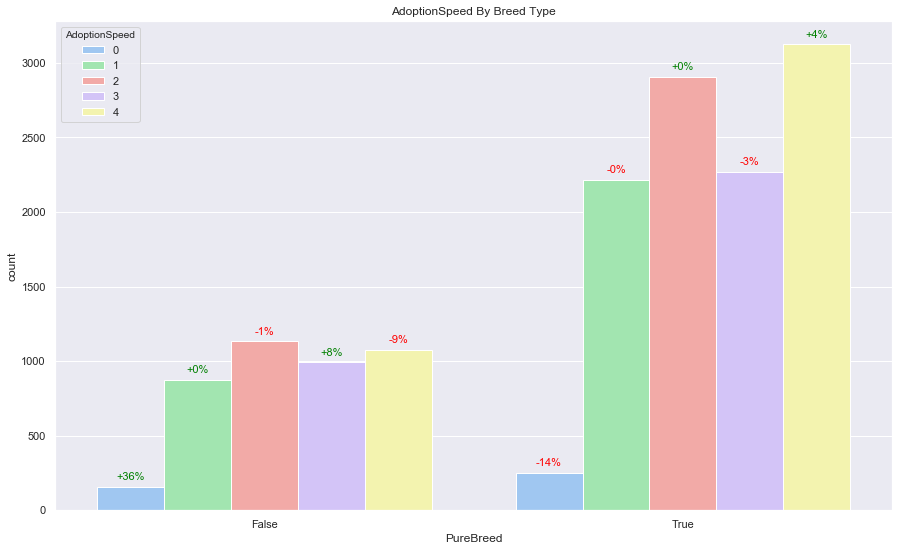

In [122]:
plt.figure(figsize=(15,9))

# plt.subplot(2, 2, 1)
count_plot(train, x='PureBreed', title='By Breed Type')

# plt.savefig('breed_type.jpg', dpi=300)

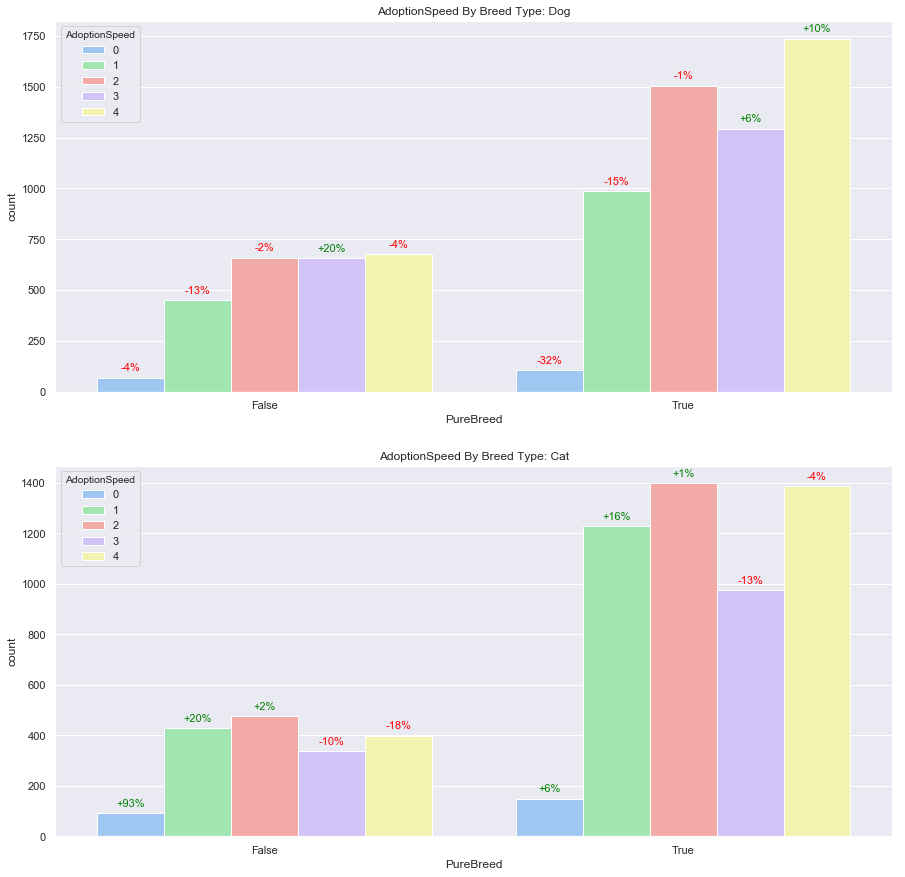

In [123]:
plt.figure(figsize=(15,15))

plt.subplot(2, 1, 1)
count_plot(df=train.loc[train['Type'] == 1], x='PureBreed', title='By Breed Type: Dog')

plt.subplot(2, 1, 2)
count_plot(df=train.loc[train['Type'] == 2], x='PureBreed', title='By Breed Type: Cat')

# plt.savefig('breed_type_2.jpg', dpi=300)

Seems like many people prefer mixed over pure breeds, especially cats.

### Gender
* 1 - Male
* 2 - Female
* 3 - Group

In [215]:
def to_gender(x):
    if x == 1: return 'Male'
    elif x == 2: return 'Female'
    elif x == 3: return 'Group'
    
    raise ValueError('Invalid Gender:' + x)
    
train['GenderType'] = train['Gender'].map(to_gender)
test['GenderType'] = test['Gender'].map(to_gender)
test['GenderType'] = test['Gender'].map(to_gender)

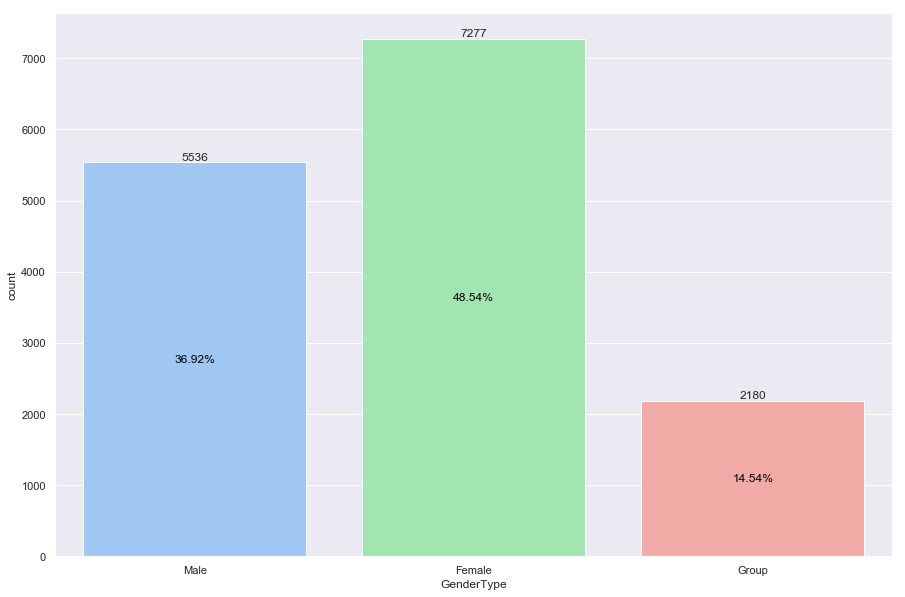

In [125]:
plt.figure(figsize=(15, 10))

ax = sns.countplot(x='GenderType', data=train)
show_percentage(ax, ax.patches, train.shape[0])
show_values(ax, ax.patches)

# plt.savefig('gender_counts.jpg', dpi=300)

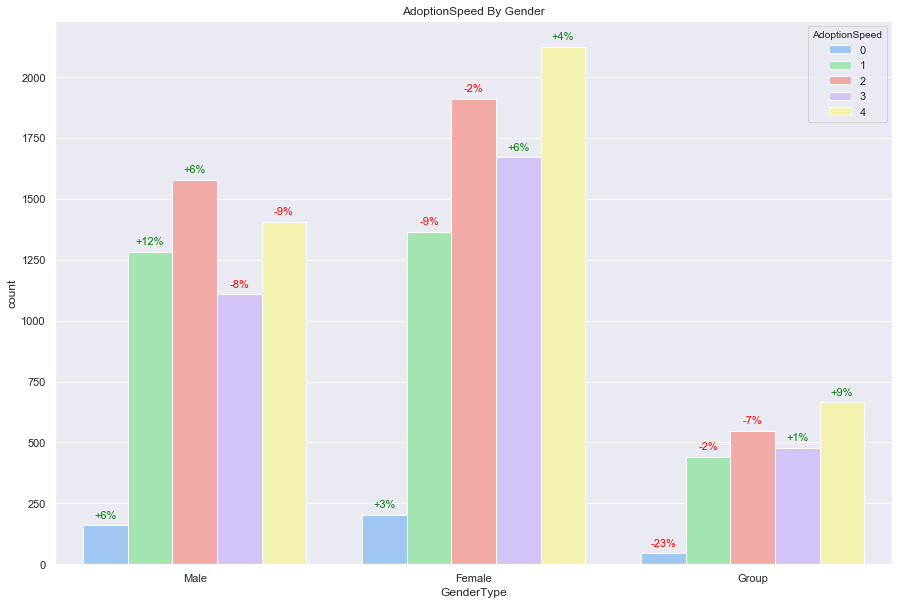

In [126]:
plt.figure(figsize=(15,10))
count_plot(df=train, x='GenderType', title='By Gender')

# plt.savefig('gender_speed.jpg', dpi=300)

Looks like male animals are slightly more preferred than the other two. People tend to not choose a group.

### Color
Let's check out if animals' colors have effect on adoption speed.

In [176]:
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}

In [216]:
train['Color1_Name'] = train['Color1'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
train['Color2_Name'] = train['Color2'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
train['Color3_Name'] = train['Color3'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')

test['Color1_Name'] = test['Color1'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
test['Color2_Name'] = test['Color2'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
test['Color3_Name'] = test['Color3'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')

data['Color1_Name'] = data['Color1'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
data['Color2_Name'] = data['Color2'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')
data['Color3_Name'] = data['Color3'].apply(lambda color: colors_dict[color] if color in colors_dict else '-')

Text(0.5, 1.0, 'Color 3 Count')

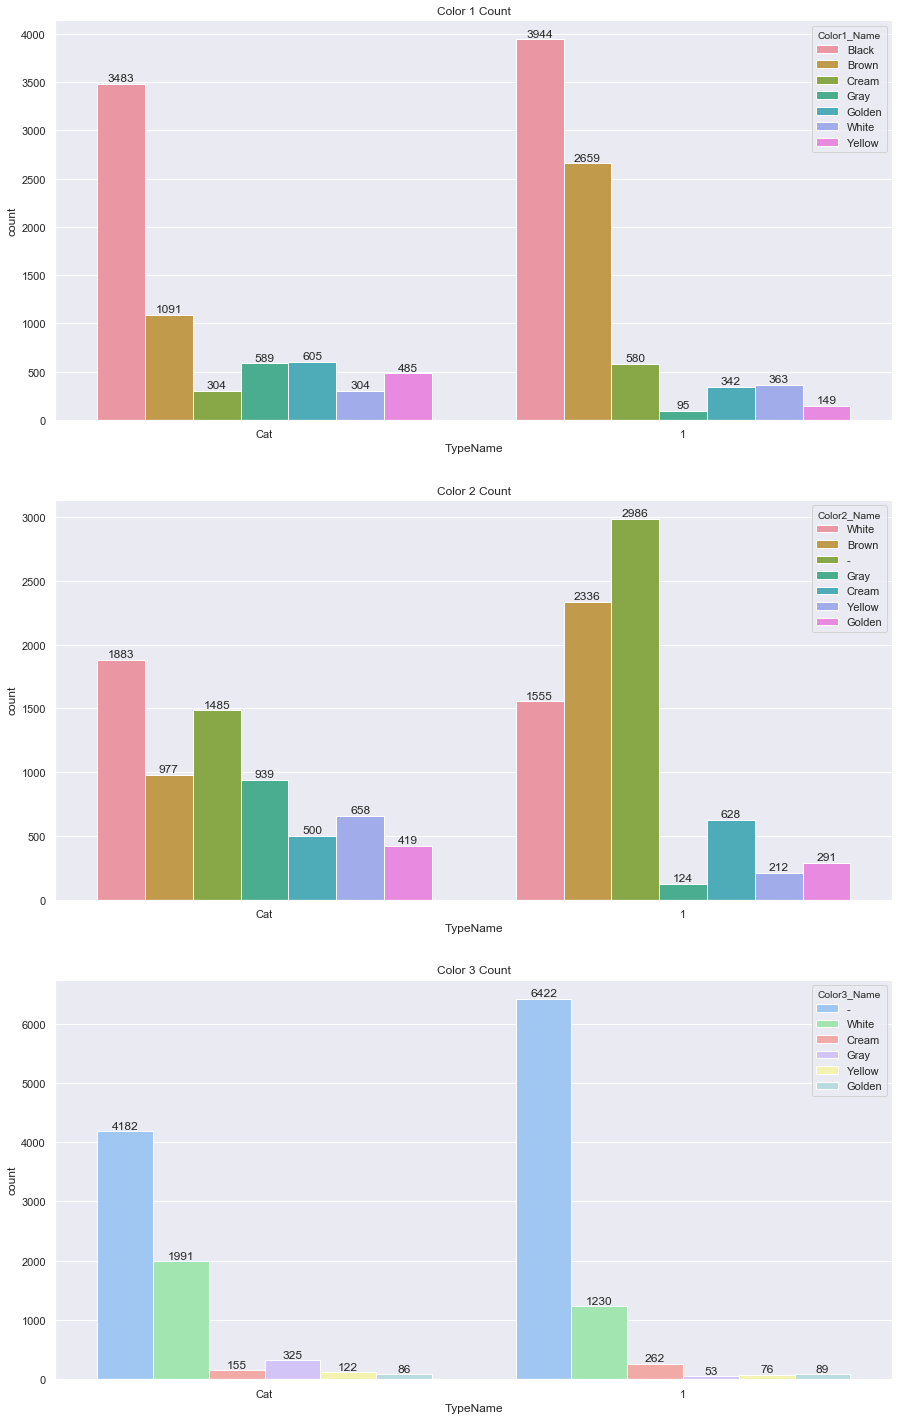

In [129]:
plt.figure(figsize=(15,25))

# palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']
plt.subplot(3, 1, 1)
ax = sns.countplot(x='TypeName', hue='Color1_Name', data=train)
show_values(ax, ax.patches)
plt.title('Color 1 Count')

plt.subplot(3, 1, 2)
ax = sns.countplot(x='TypeName', hue='Color2_Name', data=train)
show_values(ax, ax.patches)
plt.title('Color 2 Count')

plt.subplot(3, 1, 3)
ax = sns.countplot(x='TypeName', hue='Color3_Name', data=train)
show_values(ax, ax.patches)
plt.title('Color 3 Count')

# plt.savefig('colors_count.jpg', dpi=300)

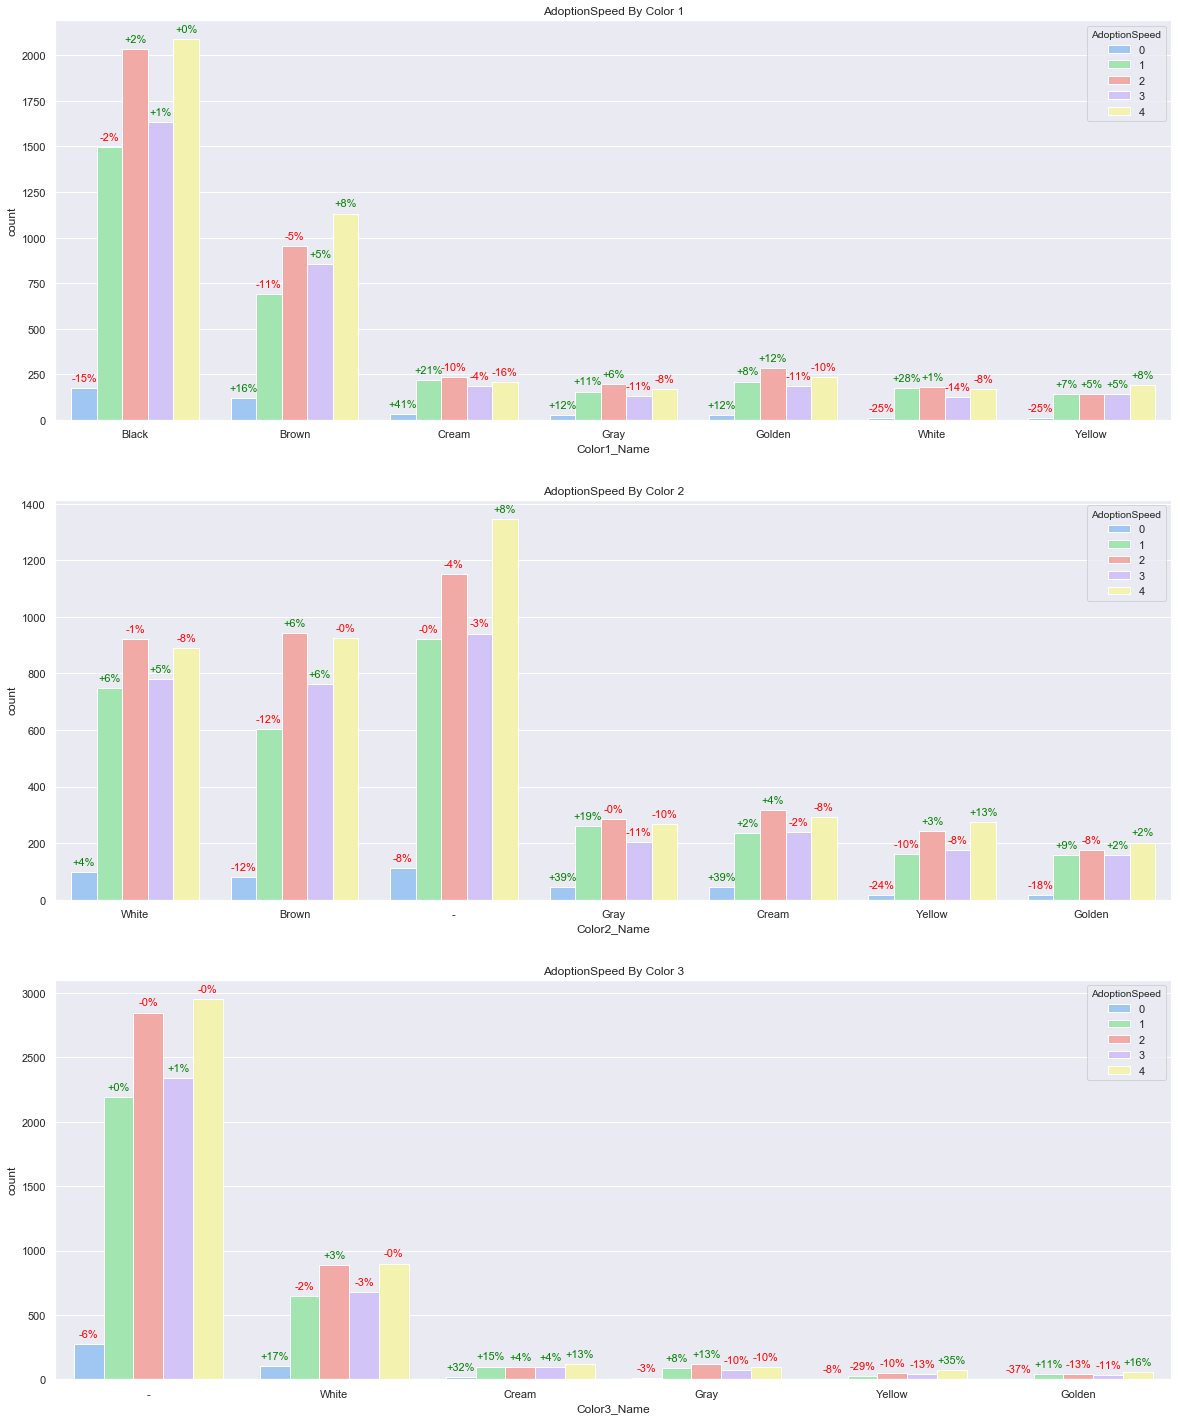

In [130]:
plt.figure(figsize=(20, 25))

plt.subplot(3, 1, 1)
count_plot(df=train, x='Color1_Name', title='By Color 1')

plt.subplot(3, 1, 2)
count_plot(df=train, x='Color2_Name', title='By Color 2')

plt.subplot(3, 1, 3)
count_plot(df=train, x='Color3_Name', title='By Color 3')

# plt.savefig('colors_speed.jpg', dpi=300)

It's apparent that the color cream is the most popular among all. It could be due to randomness because the some colors are more rare than others.

### Health/Immunization
Animals are in these datasets are in different health conditions. Some are healthy, some are injured, some are vaccinated (or not), etc.

The datasets provided us the following information regarding health:
* Vaccination
    * 1 - Yes
    * 2 - No
    * 3 - Unsure
* Deworming
    * 1 - Yes
    * 2 - No
    * 3 - Unsure
* Sterilization
    * 1 - Yes
    * 2 - No
    * 3 - Unsure
* Injuries
    * 1 - Healthy
    * 2 - Minor Injury
    * 3 - Serious Injury
    * 0 - Unsure

In [178]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Dataset', 'TypeName', 'Unnamed', 'ShortName', 'PureBreed',
       'Breed1_Name', 'Breed2_Name', 'GenderType', 'Color1_Name',
       'Color2_Name', 'Color3_Name'],
      dtype='object')

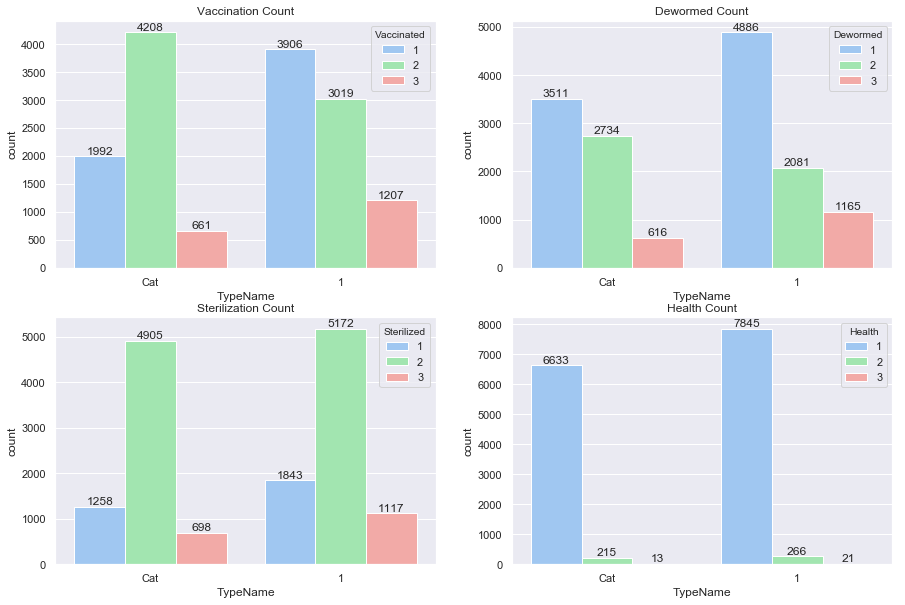

In [132]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
ax = sns.countplot(x='TypeName', hue='Vaccinated', data=train)
plt.title('Vaccination Count')
show_values(ax, ax.patches)

plt.subplot(2, 2, 2)
ax = sns.countplot(x='TypeName', hue='Dewormed', data=train)
plt.title('Dewormed Count')
show_values(ax, ax.patches)

plt.subplot(2, 2, 3)
ax = sns.countplot(x='TypeName', hue='Sterilized', data=train)
plt.title('Sterilization Count')
show_values(ax, ax.patches)

plt.subplot(2, 2, 4)
ax = sns.countplot(x='TypeName', hue='Health', data=train)
plt.title('Health Count')
show_values(ax, ax.patches)

# plt.savefig('health_counts.jpg', dpi=300)

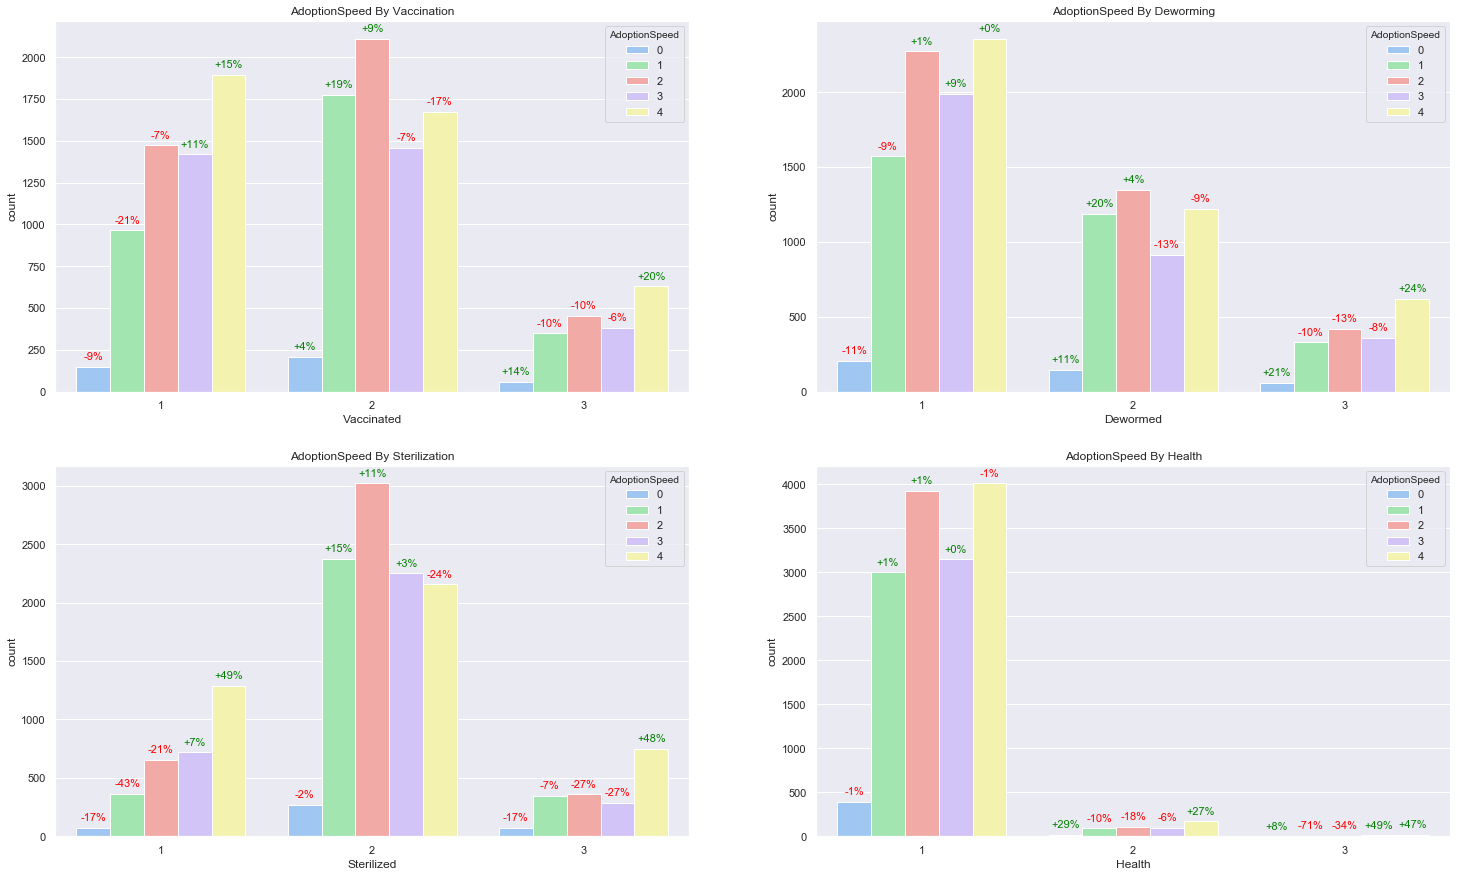

In [133]:
plt.figure(figsize=(25, 15))

plt.subplot(2, 2, 1)
count_plot(df=train, x='Vaccinated', title='By Vaccination')
plt.subplot(2, 2, 2)
count_plot(df=train, x='Dewormed', title='By Deworming')
plt.subplot(2, 2, 3)
count_plot(df=train, x='Sterilized', title='By Sterilization')
plt.subplot(2, 2, 4)
count_plot(df=train, x='Health', title='By Health')

plt.savefig('health_speed.jpg', dpi=300)

Seems like many people prefer unhandled animals over those who are vaccinated, dewormed, and sterilized. That's unexpected. Perhaps they like to have more control and assurance over such conditions. 

It's worth mentioning that animals not in perfect health conditions appear to be taken care of. Those that are slightly or severely injured are not overlooked, but the lack of sufficient data for those ones might also have an impact.

### Fee

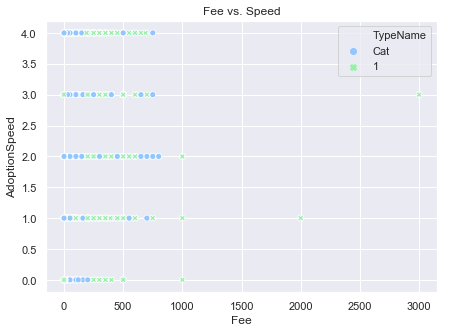

In [134]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x='Fee', y='AdoptionSpeed', hue='TypeName', style='TypeName', color='.2', data=train)
plt.title('Fee vs. Speed')
plt.savefig('fee_speed.jpg', dpi=300)

Most animals are free or within the 500 range. It's difficult to see clearly in the scatter plot, but there are only a few outliers.

Let's instead generalize to either free or not free.

In [217]:
train['Free'] = True
train.loc[train['Fee'] > 0, 'Free'] = False

test['Free'] = True
test.loc[test['Fee'] > 0, 'Free'] = False

data['Free'] = True
data.loc[data['Fee'] > 0, 'Free'] = False

Text(0.5, 1.0, 'Free Counts')

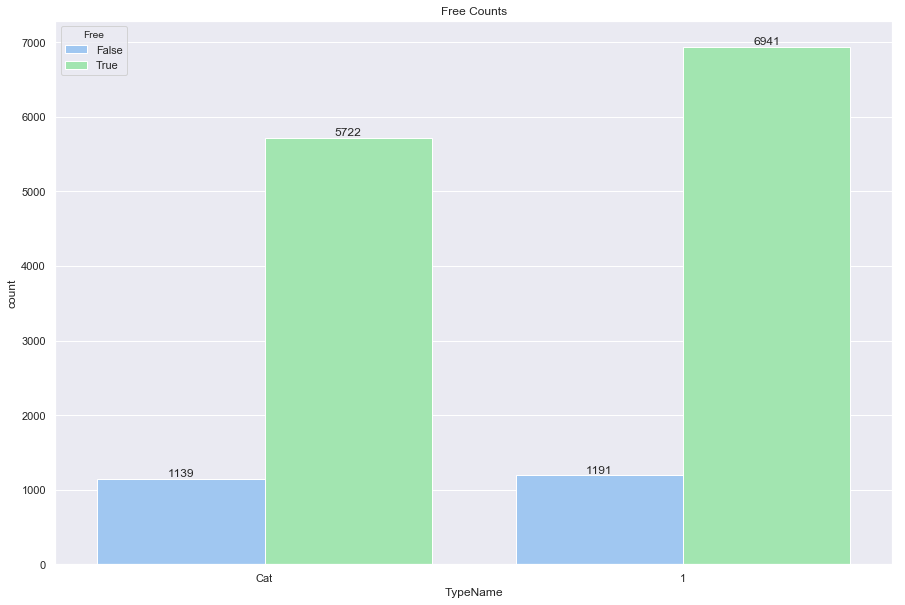

In [136]:
plt.figure(figsize=(15, 10))
ax = sns.countplot(x='TypeName', hue='Free', data=train)
show_values(ax, ax.patches)
plt.title('Free Counts')

# plt.savefig('free_counts.jpg', dpi=300)

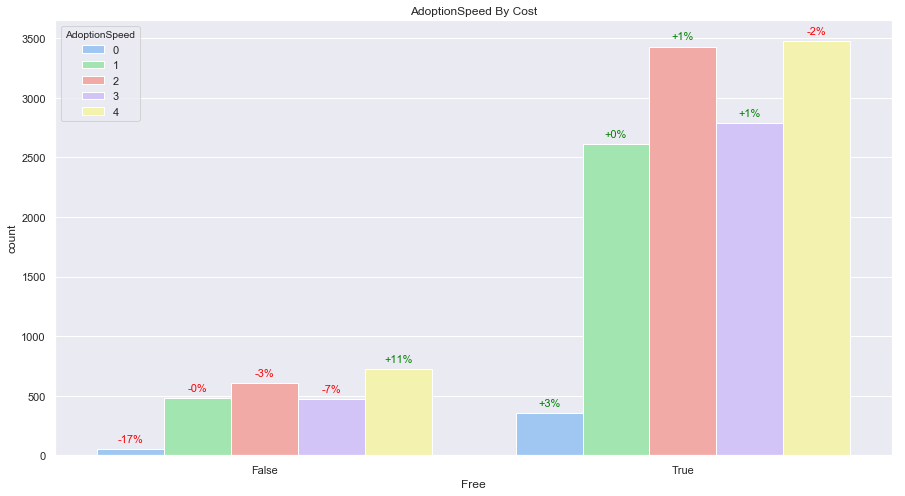

In [137]:
plt.figure(figsize=(15, 8))
count_plot(df=train, x='Free', title='By Cost')

# plt.savefig('free_speed.jpg', dpi=300)

Looks like free ones are more preferred, which makes sense.

### Description
Does the description of an animal matter? For me, it would. But let's check it out.

(-0.5, 1499.5, 1499.5, -0.5)

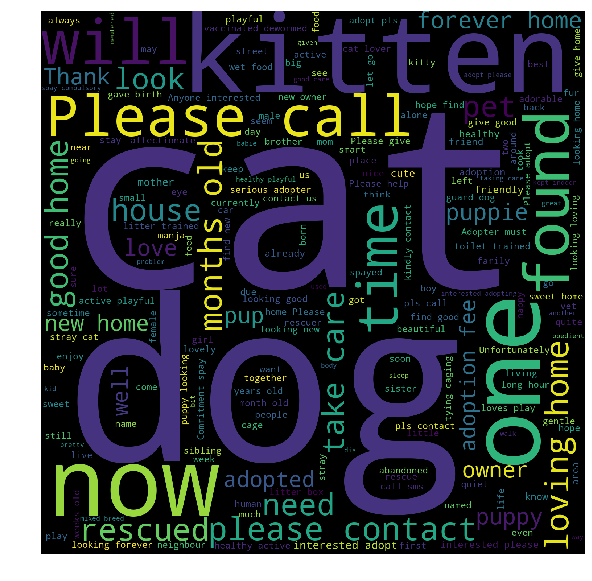

In [138]:
plt.figure(figsize=(10, 10))
wordcloud = WordCloud(width=1500, height=1500).generate(''.join(train['Description'].fillna('').values))
plt.imshow(wordcloud)
plt.axis('off')

# plt.savefig('top_descriptions.jpg', dpi=300)

We can see a lot of general words that will not contribute to our analysis.

To analyze different words and their moods(+/-), we could make use of some libraries, including SciKit Learn and ELI5.

In [180]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import eli5

'done'

'done'

In [140]:
tok = TweetTokenizer()
vec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tok.tokenize)

vec.fit(data['Description'].fillna('').values)
X_train = vec.transform(train['Description'].fillna(''))

clf = RandomForestClassifier(n_estimators=20)
# clf.fit(X_train, train['AdoptionSpeed'])

'done'

'done'

In [141]:
clf.fit(X_train, train['AdoptionSpeed'])
'done'

'done'

In [142]:
from IPython.display import display

for i in range(5):
    print('Example description of adoption speed %d:' % i)
    des = train.loc[train['AdoptionSpeed'] == i, 'Description'].values[0]
    print(des)
    display(eli5.show_prediction(clf, doc=des, vec=vec, top=10))

Example description of adoption speed 0:
I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.


Example description of adoption speed 1:
anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.


Example description of adoption speed 2:
Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.


Example description of adoption speed 3:
Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.


Example description of adoption speed 4:
Very manja and gentle stray cat found, we would really like to find a home for it because we cannot keep her for ourselves for long. Has a very cute high pitch but soft meow. Please contact me if you would be interested in adopting.


## Modeling

### Naive Multiclass LGB

In [257]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import cohen_kappa_score
from catboost import CatBoostClassifier
from tqdm import tqdm_notebook

import time
import gc
import lightgbm as lgb
import xgboost as xgb

'done'

# for i in list(train.columns):
#     if i not in list(test.columns): print(i)

'done'

In [219]:
cols_to_use = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
               'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
               'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID', 
               'Free', 'VideoAmt', 'PhotoAmt', 'AdoptionSpeed', 'Unnamed', 'ShortName', 
               'PureBreed']
train_ = train[[col for col in cols_to_use if col in train.columns]]
test_ = test[[col for col in cols_to_use if col in test.columns]]

In [ ]:
cols = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'State', 'RescuerID', 'Free',
       'Unnamed', 'ShortName', 'PureBreed']

more_cols = []
for col1 in cols:
    for col2 in cols:
        if col1 != col2 and col1 not in ['RescuerID', 'State'] and col2 not in ['RescuerID', 'State']:
            train_[col1 + '_' + col2] = train[col1].astype(str) + '_' + train[col2].astype(str)
            test_[col1 + '_' + col2] = test[col1].astype(str) + '_' + test[col2].astype(str)
            more_cols.append(col1 + '_' + col2)
            
cols = cols + more_cols

In [254]:
y = train['AdoptionSpeed']

In [258]:
%%time
indexer = {}
for col in cols:
    # print(col)
    _, indexer[col] = pd.factorize(train_[col].astype(str))
    
for col in tqdm_notebook(cols):
    # print(col)
    train_[col] = indexer[col].get_indexer(train_[col].astype(str))
    test_[col] = indexer[col].get_indexer(test_[col].astype(str))


CPU times: user 11.1 s, sys: 773 ms, total: 11.9 s
Wall time: 11.9 s


In [259]:
n_fold = 3
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=43)

In [267]:
def train_model(X=train_, X_test=test_, y=y, cols=cols, params=None, folds=folds, model_type='lgb', 
               plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros((len(X_test), 5))
    prediction = np.zeros((len(X_test), 5))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n+1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        cols = cols
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cols)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds=200)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=100, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'lcv':
            model = LogisticRegressionCV(scoring='neg_log_loss', cv=3, multi_class='multinomial')
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  loss_function='MultiClass', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test).reshape(-1,)
        
        if make_oof:
            oof[valid_index] = y_pred_valid
            
        scores.append(cohen_kappa_score(y_valid, y_pred_valid.argmax(1)))
        print('Fold kappa:', cohen_kappa_score(y_valid, y_pred_valid.argmax(1)))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [268]:
params = {'num_leaves': 512,
#          'min_data_in_leaf': 60,
         'objective': 'multiclass',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 3,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
#          "lambda_l1": 0.1,
#          "lambda_l2": 0.1,
         "random_state": 42,          
         "verbosity": -1,
         "num_class": 5}

Fold 1 started at Wed Apr 17 23:20:30 2019


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's multi_logloss: 0.0109164	valid_1's multi_logloss: 0.0118973
[1000]	training's multi_logloss: 0.000108363	valid_1's multi_logloss: 0.000125353
[1500]	training's multi_logloss: 1.25929e-06	valid_1's multi_logloss: 1.50997e-06
[2000]	training's multi_logloss: 3.63993e-07	valid_1's multi_logloss: 4.61658e-07
[2500]	training's multi_logloss: 3.61332e-07	valid_1's multi_logloss: 4.56008e-07
[3000]	training's multi_logloss: 3.58356e-07	valid_1's multi_logloss: 4.50723e-07
[3500]	training's multi_logloss: 3.57168e-07	valid_1's multi_logloss: 4.48257e-07
[4000]	training's multi_logloss: 3.56861e-07	valid_1's multi_logloss: 4.47197e-07
[4500]	training's multi_logloss: 3.56152e-07	valid_1's multi_logloss: 4.45984e-07
[5000]	training's multi_logloss: 3.56081e-07	valid_1's multi_logloss: 4.45772e-07
[5500]	training's multi_logloss: 3.56038e-07	valid_1's multi_logloss: 4.4567e-07
[6000]	training's multi_logloss: 3.55994e

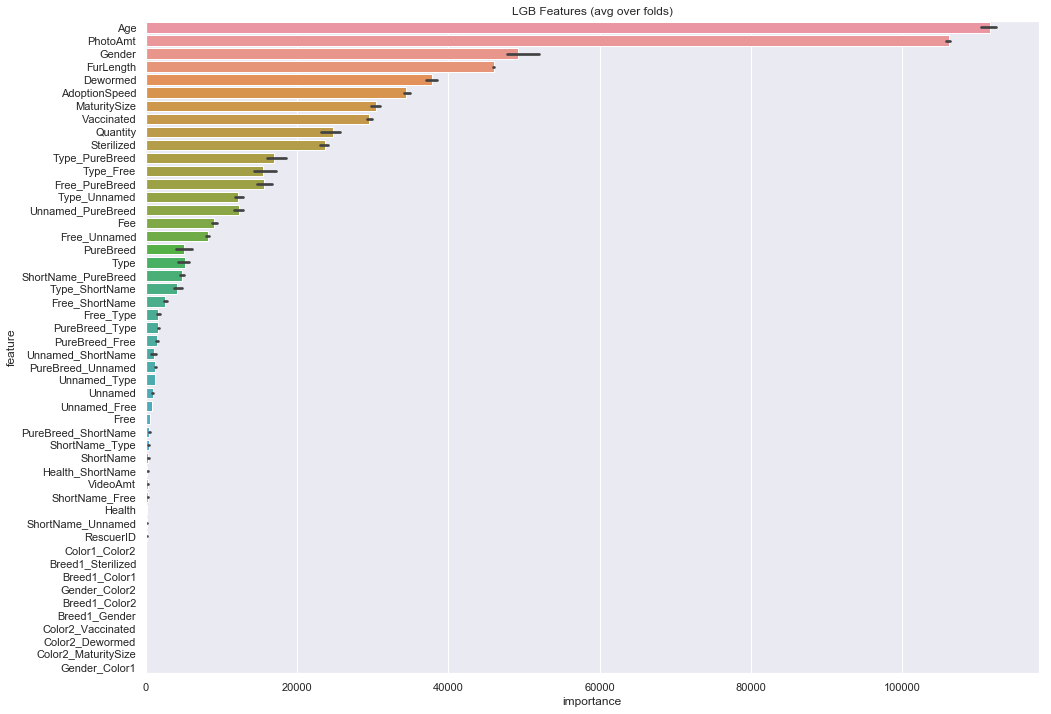

In [269]:
result_dict_lgb = train_model(X=train_, X_test=test_, y=y, cols=cols, params=params, model_type='lgb', plot_feature_importance=True, make_oof=False)



In [272]:
xgb_params = {'eta': 0.01, 'max_depth': 9, 'subsample': 0.9, 'colsample_bytree': 0.9, 
          'objective': 'multi:softprob', 'eval_metric': 'merror', 'silent': True, 'nthread': 4, 'num_class': 5}
# result_dict_xgb = train_model(params=xgb_params, model_type='xgb', make_oof=False)

In [273]:
# result_dict_lcv = train_model(model_type='lcv', make_oof=False)